# predict_T+1_tf2

## Base
### 依赖与超参数

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LSTM, Conv1D, Dropout, Bidirectional, Multiply, BatchNormalization, \
    Flatten, Lambda, Permute, RepeatVector
from tensorflow.keras.models import Model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import os
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot
from tensorflow.keras.optimizers.schedules import ExponentialDecay


import visualkeras
from PIL import ImageFont

import pathlib

In [3]:
SINGLE_ATTENTION_VECTOR = False
INPUT_DIMS = 4
TIME_STEPS = 20
batch_size = 64
lstm_units = 64
conv_filters = 64
epoch = 30
dropout = 0.4
temperature = 10  # 蒸馏温度
alpha = 0.1  # 蒸馏损失和学生损失的权重

### 模型相关函数

In [4]:
def attention_3d_block(inputs):
    input_dim = int(inputs.shape[2])
    a = inputs
    a = Dense(input_dim, activation='softmax')(a)
    if SINGLE_ATTENTION_VECTOR:
        a = Lambda(lambda x: tf.reduce_mean(x, axis=1), name='dim_reduction')(a)
        a = RepeatVector(input_dim)(a)
    a_probs = Permute((1, 2), name='attention_vec')(a)

    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul


# 多维归一化 返回数据和最大最小值
def NormalizeMult(data):
    normalize = np.arange(2 * data.shape[1], dtype='float64')

    normalize = normalize.reshape(data.shape[1], 2)
    for i in range(0, data.shape[1]):
        list = data[:, i]
        list_low, list_high = np.percentile(list, [0, 100])
        normalize[i, 0] = list_low
        normalize[i, 1] = list_high
        delta = list_high - list_low
        if delta != 0:
            for j in range(0, data.shape[0]):
                data[j, i] = (data[j, i] - list_low) / delta
    return data, normalize


# 多维反归一化
def FNormalizeMult(data, normalize):
    data = np.array(data)
    for i in range(0, data.shape[1]):
        listlow = normalize[i, 0]
        listhigh = normalize[i, 1]
        delta = listhigh - listlow
        if delta != 0:
            #第j行
            for j in range(0, data.shape[0]):
                data[j, i] = data[j, i] * delta + listlow

    return data

# 模型评估
def calculate_metrics(test_Y, pred_Y):
    mae = mean_absolute_error(test_Y, pred_Y)
    mse = mean_squared_error(test_Y, pred_Y)

    test_diff = np.diff(test_Y[:, 1])
    pred_diff = np.diff(pred_Y[:, 1])
    test_sign = np.sign(test_diff)
    pred_sign = np.sign(pred_diff)
    accuracy = np.mean(test_sign == pred_sign) * 100

    return mae, mse, accuracy

# 预测第二天价格-数据集创建
def create_dataset_tomorrow(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        dataX.append(a)
        dataY.append(dataset[i + look_back, :])
    TrainX = np.array(dataX)
    Train_Y = np.array(dataY)
    return TrainX, Train_Y

### 数据加载与划分

In [5]:
# 加载数据
data = pd.read_csv("./data.csv")
data = data[['open', 'close', 'high', 'low']]

# 归一化
data = np.array(data)
data, normalize = NormalizeMult(data)
close_column = data[:, 1].reshape(len(data), 1)

train_X, train_Y = create_dataset_tomorrow(data, TIME_STEPS)
train_X, test_X, train_Y, test_Y = train_test_split(train_X, train_Y, test_size=0.2, random_state=42)

## 直接训练并运行

In [27]:
def attention_model_with_norm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=conv_filters, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_8 (InputLayer)        [(None, 20, 4)]              0         []                            
                                                                                                  
 conv1d_7 (Conv1D)           (None, 20, 64)               320       ['input_8[0][0]']             
                                                                                                  
 batch_normalization_8 (Bat  (None, 20, 64)               256       ['conv1d_7[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_14 (Dropout)        (None, 20, 64)               0         ['batch_normalization_8[

d:\IDE-Extends\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


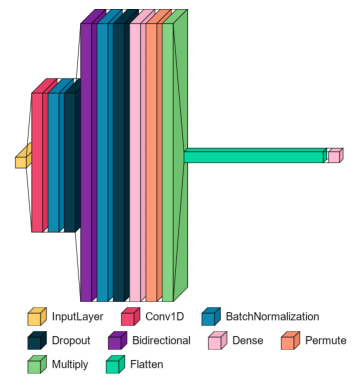

In [28]:
m = attention_model_with_norm()
m.summary()

font = ImageFont.truetype("arial.ttf", 20)
plt.imshow(visualkeras.layered_view(m, legend=True, font=font))
visualkeras.layered_view(m, legend=True, font=font).save('.assets/model.png')
plt.axis('off')
plt.show()

In [29]:
m.compile(optimizer='adam', loss='mse')
m.fit([train_X], train_Y, epochs=epoch, batch_size=batch_size, validation_split=0.1)

Epoch 1/15
296/296 [==============================] - 15s 33ms/step - loss: 0.0040 - val_loss: 0.0353
Epoch 2/15
296/296 [==============================] - 9s 30ms/step - loss: 0.0013 - val_loss: 0.0121
Epoch 3/15
296/296 [==============================] - 9s 31ms/step - loss: 0.0011 - val_loss: 5.4361e-04
Epoch 4/15
296/296 [==============================] - 9s 30ms/step - loss: 8.5050e-04 - val_loss: 0.0023
Epoch 5/15
296/296 [==============================] - 9s 30ms/step - loss: 7.9244e-04 - val_loss: 0.0037
Epoch 6/15
296/296 [==============================] - 9s 30ms/step - loss: 7.1230e-04 - val_loss: 0.0018
Epoch 7/15
296/296 [==============================] - 9s 31ms/step - loss: 6.1844e-04 - val_loss: 8.5921e-04
Epoch 8/15
296/296 [==============================] - 9s 30ms/step - loss: 5.6026e-04 - val_loss: 0.0020
Epoch 9/15
296/296 [==============================] - 9s 30ms/step - loss: 5.3733e-04 - val_loss: 0.0012
Epoch 10/15
296/296 [==============================] - 9s 

In [30]:
# 使用测试集进行预测
pred_Y_direct = m.predict(test_X)

pred_Y_denormalized_direct = FNormalizeMult(pred_Y_direct, normalize)
test_Y_denormalized_direct = FNormalizeMult(test_Y, normalize)

mae_direct, mse_direct, accuracy_direct = calculate_metrics(test_Y_denormalized_direct, pred_Y_denormalized_direct)
print(f"MAE: {mae_direct}")
print(f"MSE: {mse_direct}")
print(f"涨跌准确率: {accuracy_direct}%")

165/165 [==============================] - 2s 6ms/step
MAE: 0.011934100040550542
MSE: 0.000214573775420208
涨跌准确率: 98.89544848600266%


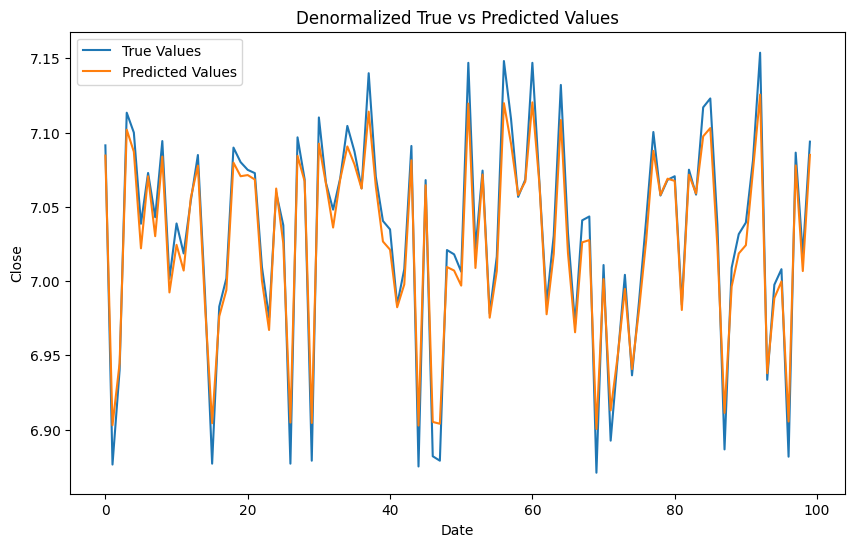

In [31]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized_direct[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized_direct[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [32]:
# m.save('check_points/model_origin')
model_saved_path = 'check_points/model_origin_saved_model'
tf.saved_model.save(m,model_saved_path)

INFO:tensorflow:Assets written to: check_points/model_origin_saved_model\assets


INFO:tensorflow:Assets written to: check_points/model_origin_saved_model\assets


In [33]:
converter = tf.lite.TFLiteConverter.from_saved_model(model_saved_path) 
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path(f"check_points/model_tflite/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_origin_file = tflite_models_dir/"model_origin_tflite.tflite"

size_origin = tflite_model_origin_file.write_bytes(tflite_model)

print(f"origin model size: {size_origin} bytes")

origin model size: 397204 bytes


## 蒸馏

In [23]:
# 蒸馏模型类
class Distiller(tf.keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha=0.1, temperature=3):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn = student_loss_fn
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        x, y = data

        # 教师模型输出
        teacher_predictions = self.teacher(x, training=False)

        with tf.GradientTape() as tape:
            # 学生模型输出
            student_predictions = self.student(x, training=True)

            # 计算学生的损失
            student_loss = self.student_loss_fn(y, student_predictions)

            # 计算蒸馏损失（使用温度处理的softmax）
            distillation_loss = self.distillation_loss_fn(
                tf.nn.softmax(teacher_predictions / self.temperature, axis=1),
                tf.nn.softmax(student_predictions / self.temperature, axis=1),
            )

            # 总损失
            loss = self.alpha * student_loss + (1 - self.alpha) * distillation_loss

        # 计算梯度并更新学生模型的权重
        gradients = tape.gradient(loss, self.student.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.student.trainable_variables))

        # 更新metrics
        self.compiled_metrics.update_state(y, student_predictions)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
        return results

    def call(self, inputs):
        # 在这里，我们定义了Distiller的call方法，即通过学生模型进行前向传播
        student_predictions = self.student(inputs, training=False)
        return student_predictions

    def test_step(self, data):
        x, y = data
        y_prediction = self.student(x, training=False)
        student_loss = self.student_loss_fn(y, y_prediction)
        self.compiled_metrics.update_state(y, y_prediction)

        results = {m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        return results

In [24]:
def teacher_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=conv_filters, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(4, activation='linear')(attention_mul)  # 教师模型输出4个特征
    model = Model(inputs=[inputs], outputs=output)
    return model

# 定义学生模型
def student_model():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=conv_filters // 2, kernel_size=1, activation='relu')(inputs)  # 较少的过滤器
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units // 3, return_sequences=True))(x)  # 更少的LSTM单元
    lstm_out = Dropout(dropout)(lstm_out)
    # attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(lstm_out)
    output = Dense(4, activation='linear')(attention_mul)  # 学生模型输出4个特征
    model = Model(inputs=[inputs], outputs=output)
    return model

In [26]:
# 创建教师模型和学生模型
teacher = teacher_model()
student = student_model()

# 训练教师模型
teacher.compile(optimizer='adam', loss='mse')
teacher.fit([train_X], train_Y, epochs=epoch, batch_size=batch_size, validation_split=0.1)

# 创建蒸馏模型并训练学生模型
distiller = Distiller(student=student, teacher=teacher)
distiller.compile(
    optimizer='adam',
    metrics=['mae'],
    student_loss_fn=tf.keras.losses.MeanSquaredError(),
    distillation_loss_fn=tf.keras.losses.KLDivergence(),
    alpha=alpha,
    temperature=temperature
)

# 训练蒸馏模型
distiller.fit(train_X, train_Y, epochs=epoch, batch_size=batch_size, validation_split=0.1)

Epoch 1/15
296/296 [==============================] - 15s 38ms/step - loss: 0.0190 - val_loss: 0.0287
Epoch 2/15
296/296 [==============================] - 9s 31ms/step - loss: 0.0024 - val_loss: 0.0070
Epoch 3/15
296/296 [==============================] - 9s 31ms/step - loss: 0.0018 - val_loss: 0.0021
Epoch 4/15
296/296 [==============================] - 9s 31ms/step - loss: 0.0015 - val_loss: 0.0017
Epoch 5/15
296/296 [==============================] - 9s 31ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 6/15
296/296 [==============================] - 9s 30ms/step - loss: 0.0011 - val_loss: 0.0031
Epoch 7/15
296/296 [==============================] - 9s 30ms/step - loss: 0.0010 - val_loss: 0.0025
Epoch 8/15
296/296 [==============================] - 9s 31ms/step - loss: 9.4625e-04 - val_loss: 0.0029
Epoch 9/15
296/296 [==============================] - 9s 31ms/step - loss: 7.9378e-04 - val_loss: 0.0035
Epoch 10/15
296/296 [==============================] - 9s 31ms/step - loss: 8.2522

In [34]:
# 使用测试集进行预测
pred_Y_distill = distiller.predict(test_X)
pred_Y_denormalized_distill = FNormalizeMult(pred_Y_distill, normalize)
test_Y_denormalized_distill = FNormalizeMult(test_Y, normalize)

# 计算评价指标
mae_distill, mse_distill, accuracy_distill = calculate_metrics(test_Y_denormalized_distill, pred_Y_denormalized_distill)
print(f"MAE: {mae_distill}")
print(f"MSE: {mse_distill}")
print(f"涨跌准确率: {accuracy_distill}%")

165/165 [==============================] - 1s 3ms/step
MAE: 0.004694127545244164
MSE: 3.724650134934323e-05
涨跌准确率: 98.3812607122453%


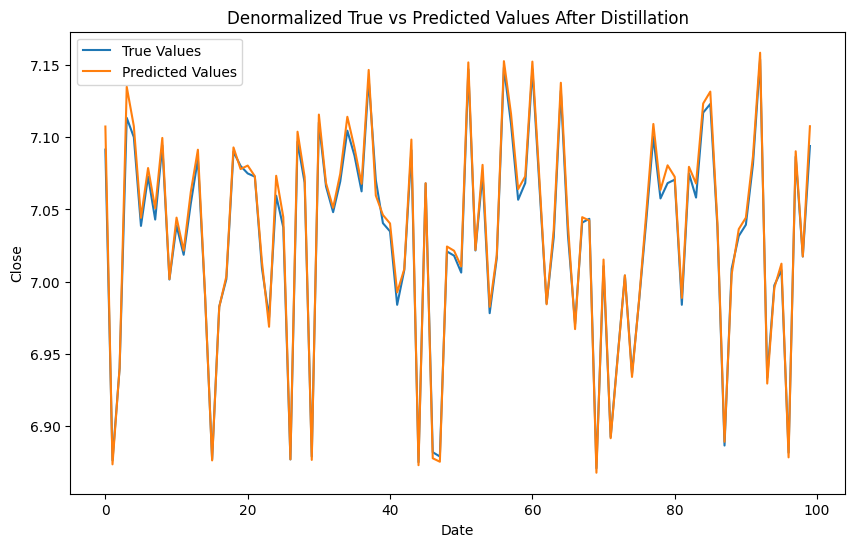

In [35]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized_distill[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized_distill[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values After Distillation')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 20, 4)]              0         []                            
                                                                                                  
 conv1d_3 (Conv1D)           (None, 20, 64)               320       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_2 (Bat  (None, 20, 64)               256       ['conv1d_3[0][0]']            
 chNormalization)                                                                                 
                                                                                                  
 dropout_6 (Dropout)         (None, 20, 64)               0         ['batch_normalization_2[

d:\IDE-Extends\Python\Python311\Lib\site-packages\visualkeras\layered.py:86: UserWarning: The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.
  warnings.warn("The legend_text_spacing_offset parameter is deprecated and will be removed in a future release.")


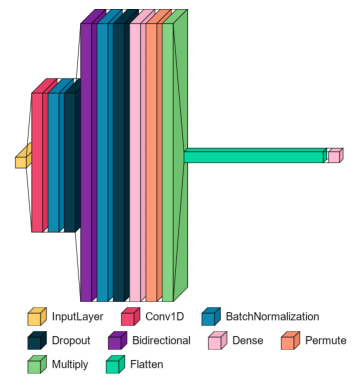

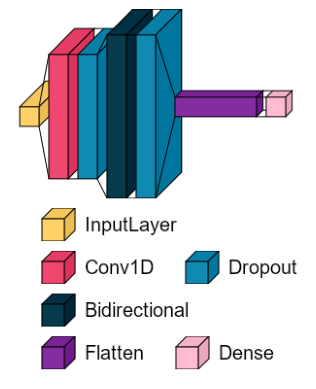

In [27]:
teacher.summary()
student.summary()

font = ImageFont.truetype("arial.ttf", 20)
plt.imshow(visualkeras.layered_view(teacher, legend=True, font=font))
visualkeras.layered_view(teacher, legend=True, font=font).save('.assets/teacher.png')
plt.axis('off')
plt.show()

font = ImageFont.truetype("arial.ttf", 20)
plt.imshow(visualkeras.layered_view(student, legend=True, font=font))
visualkeras.layered_view(student, legend=True, font=font).save('.assets/student.png')
plt.axis('off')
plt.show()

In [1]:
from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2

def get_flops(model):
    # Convert the model to a concrete function
    concrete_func = tf.function(lambda x: model(x))
    concrete_func = concrete_func.get_concrete_function(
        tf.TensorSpec([1] + list(model.input_shape[1:]))
    )
    # Freeze the concrete function to get a static graph
    frozen_func = convert_variables_to_constants_v2(concrete_func)
    graph_def = frozen_func.graph.as_graph_def()

    # Use the TensorFlow v1 profiler to calculate FLOPs
    with tf.Graph().as_default() as graph:
        tf.import_graph_def(graph_def, name="")
        run_meta = tf.compat.v1.RunMetadata()
        opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
        flops = tf.compat.v1.profiler.profile(
            graph=graph, run_meta=run_meta, cmd="op", options=opts
        )
        return flops.total_float_ops if flops is not None else 0

In [ ]:
# Initialize models with sample input to ensure they are built
sample_input = tf.random.normal([1, TIME_STEPS, INPUT_DIMS])
teacher(sample_input)
student(sample_input)

# Calculate FLOPs
teacher_flops = get_flops(teacher)
student_flops = get_flops(student)

print(f"教师模型 FLOPs: {teacher_flops}")
print(f"学生模型 FLOPs: {student_flops}")

In [ ]:
# student.save('check_points/student')
student_saved_path = 'check_points/student_saved_model'
teacher_saved_path = 'check_points/teacher_saved_model'
tf.saved_model.save(student,student_saved_path)
tf.saved_model.save(teacher,teacher_saved_path)


INFO:tensorflow:Assets written to: check_points/student_saved_model\assets


INFO:tensorflow:Assets written to: check_points/student_saved_model\assets


INFO:tensorflow:Assets written to: check_points/teacher_saved_model\assets


INFO:tensorflow:Assets written to: check_points/teacher_saved_model\assets


In [39]:
def get_folder_size(folder_path):
    total_size = 0
    # 遍历文件夹及其子文件夹
    for dirpath, dirnames, filenames in os.walk(folder_path):
        for file in filenames:
            # 获取每个文件的完整路径
            file_path = os.path.join(dirpath, file)
            # 累加文件的大小
            total_size += os.path.getsize(file_path)
    return total_size

size = get_folder_size(student_saved_path)

# 输出文件夹大小，单位为 MB
print(f"Folder size: {size / 8:.2f} B")

size = get_folder_size(teacher_saved_path)
print(f"Folder size: {size / 8:.2f} B")

Folder size: 260198.38 B
Folder size: 419789.25 B


In [41]:
converter = tf.lite.TFLiteConverter.from_saved_model(student_saved_path) 
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path(f"check_points/model_tflite/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_student_file = tflite_models_dir/"model_student_tflite.tflite"

size_student = tflite_model_student_file.write_bytes(tflite_model)

print(f"student model size: {size_student} bytes")

student model size: 67668 bytes


In [47]:
student.save('check_points/student')

INFO:tensorflow:Assets written to: check_points/student\assets


INFO:tensorflow:Assets written to: check_points/student\assets


## 剪枝（废）

In [7]:
logdir = "./logs"

callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

student_to_prune  = tf.keras.models.load_model('check_points/student')

student_to_prune.compile(optimizer='adam', loss='mse')

student_to_prune.summary()

student_to_prune.fit(train_X, train_Y,
            batch_size=batch_size,
            epochs=3,
            validation_split=0.2,
            callbacks=callbacks)


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 20, 4)]           0         
                                                                 
 conv1d_6 (Conv1D)           (None, 20, 32)            160       
                                                                 
 dropout_12 (Dropout)        (None, 20, 32)            0         
                                                                 
 bidirectional_6 (Bidirecti  (None, 20, 42)            9072      
 onal)                                                           
                                                                 
 dropout_13 (Dropout)        (None, 20, 42)            0         
                                                                 
 flatten_6 (Flatten)         (None, 840)               0         
                                                           

In [8]:
# 使用测试集进行预测
pred_Y_purning = student_to_prune.predict(test_X)
pred_Y_denormalized_purning = FNormalizeMult(pred_Y_purning, normalize)
test_Y_denormalized_purning = FNormalizeMult(test_Y, normalize)

# 计算评价指标
mae_purning, mse_purning, accuracy_purning = calculate_metrics(test_Y_denormalized_purning, pred_Y_denormalized_purning)
print(f"MAE: {mae_purning}")
print(f"MSE: {mse_purning}")
print(f"涨跌准确率: {accuracy_purning}%")

165/165 [==============================] - 1s 3ms/step
MAE: 0.0026382162447476853
MSE: 1.6746965018603193e-05
涨跌准确率: 98.36221672062464%


In [10]:
student_to_prune(sample_input)

# Calculate FLOPs
student_to_prune_flops = get_flops(student_to_prune)

print(f"剪枝模型 FLOPs: {student_to_prune_flops}")

Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
剪枝模型 FLOPs: 5760


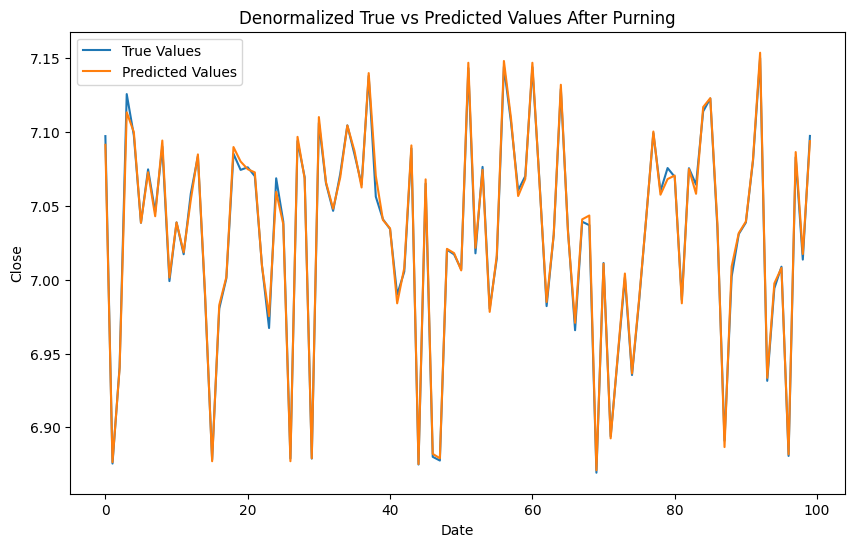

In [50]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(pred_Y_denormalized_purning[:100, 1], label='True Values')
plt.plot(test_Y_denormalized_purning[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values After Purning')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

In [51]:
# student_to_prune.save('check_points/student_after_prune')

student_to_prune_path = 'check_points/student_after_prune_saved_model'
tf.saved_model.save(student_to_prune,student_to_prune_path)

INFO:tensorflow:Assets written to: check_points/student_after_prune_saved_model\assets


INFO:tensorflow:Assets written to: check_points/student_after_prune_saved_model\assets


In [52]:
converter = tf.lite.TFLiteConverter.from_saved_model(student_to_prune_path) 
converter._experimental_lower_tensor_list_ops = False
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
tflite_model = converter.convert()

tflite_models_dir = pathlib.Path(f"check_points/model_tflite/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_prune_file = tflite_models_dir/"model_prune_tflite.tflite"

size_prune = tflite_model_prune_file.write_bytes(tflite_model)

print(f"prune model size: {size_prune} bytes")

prune model size: 67668 bytes


## 量化

### 量化学生模型（转为 TFLite 模型）

In [53]:
# 加载已保存的模型

# converter = tf.lite.TFLiteConverter.from_saved_model('check_points/student_saved_model')

converter = tf.lite.TFLiteConverter.from_keras_model(student_to_prune)


# 启用量化
converter.optimizations = []  
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]  
converter._experimental_lower_tensor_list_ops = False  # 禁用 TensorList 的转换


def representative_data_gen():
    for input_value in train_X:
        yield [input_value.astype(np.float32)]

converter.representative_dataset = representative_data_gen

# 转换为量化的 TFLite 模型
tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\21343\AppData\Local\Temp\tmp6y1lxkv0\assets


INFO:tensorflow:Assets written to: C:\Users\21343\AppData\Local\Temp\tmp6y1lxkv0\assets


In [54]:
# 保存量化后的模型
tflite_models_dir = pathlib.Path(f"check_points/model_tflite/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

tflite_model_quant_file = tflite_models_dir/"student_model_prune_quant.tflite"
# tflite_model_quant_file = tflite_models_dir/"student_model_direct_quant.tflite"
size_quant = tflite_model_quant_file.write_bytes(tflite_model_quant)

print(f"Quantized model size: {size_quant} bytes")

Quantized model size: 67540 bytes


### 进行量化后模型的推理

In [55]:
def run_tflite_model(tflite_file, test_image_indices):
    global test_X, test_Y

    # 加载量化后的 TFLite 模型
    interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()[0]
    output_details = interpreter.get_output_details()[0]

    predictions = np.zeros((len(test_image_indices), 4), dtype=float)  # 假设输出是4个特征

    for i, test_image_index in enumerate(test_image_indices):
        test_image = test_X[test_image_index]

        # 量化输入数据
        if input_details['dtype'] == np.uint8:
            input_scale, input_zero_point = input_details["quantization"]
            test_image = test_image / input_scale + input_zero_point

        # 扩展维度并转换数据类型
        test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])

        # 将输入数据传入模型
        interpreter.set_tensor(input_details['index'], test_image)

        # 执行推理
        interpreter.invoke()

        # 获取输出
        output = interpreter.get_tensor(output_details['index'])[0]

        # 存储预测结果
        predictions[i] = output

    return predictions


test_indices = range(test_X.shape[0])
predictions = run_tflite_model(tflite_model_quant_file, test_indices)
pred_Y_denormalized_quant = FNormalizeMult(predictions, normalize)
test_Y_denormalized_quant = FNormalizeMult(test_Y, normalize)

mae_quant, mse_quant, accuracy_quant = calculate_metrics(test_Y_denormalized_quant, pred_Y_denormalized_quant)

print(f'Quantized Student model evaluation results:')
print(f"MAE: {mae_quant}")
print(f"MSE: {mse_quant}")
print(f"涨跌准确率: {accuracy_quant}%")


Quantized Student model evaluation results:
MAE: 0.0025846275441582184
MSE: 1.652983449001635e-05
涨跌准确率: 98.40030470386593%


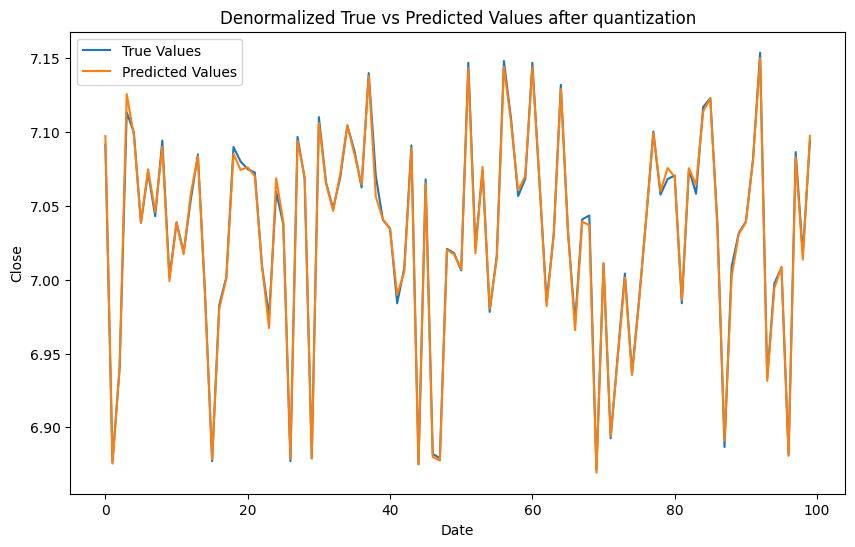

In [56]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized_quant[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized_quant[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values after quantization')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

## 对比实验（消融
### 直接训练学生模型

In [21]:
def attention_model():
    # inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    # x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    # x = Dropout(dropout)(x)
    # lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    # lstm_out = Dropout(dropout)(lstm_out)
    # attention_mul = attention_3d_block(lstm_out)
    # attention_mul = Flatten()(attention_mul)
    # output = Dense(4, activation='linear')(attention_mul)  # Output layer adjusted for 4 features
    # model = Model(inputs=[inputs], outputs=output)
    # return model
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=32, kernel_size=1, activation='relu')(inputs)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units // 3, return_sequences=True))(x)  
    lstm_out = Dropout(dropout)(lstm_out)
    # attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(lstm_out)
    output = Dense(4, activation='linear')(attention_mul)  
    model = Model(inputs=[inputs], outputs=output)
    return model

def attention_model_with_norm():
    inputs = Input(shape=(TIME_STEPS, INPUT_DIMS))
    x = Conv1D(filters=64, kernel_size=1, activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Dropout(dropout)(x)
    lstm_out = Bidirectional(LSTM(lstm_units, return_sequences=True))(x)
    lstm_out = BatchNormalization()(lstm_out)
    lstm_out = Dropout(dropout)(lstm_out)
    attention_mul = attention_3d_block(lstm_out)
    attention_mul = Flatten()(attention_mul)
    output = Dense(1, activation='sigmoid')(attention_mul)
    model = Model(inputs=[inputs], outputs=output)
    return model

In [22]:
m = attention_model()

m.summary()
m.compile(optimizer='adam', loss='mse')
m.fit([train_X], train_Y, epochs=epoch, batch_size=64, validation_split=0.1)

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 20, 4)]           0         
                                                                 
 conv1d_3 (Conv1D)           (None, 20, 32)            160       
                                                                 
 dropout_6 (Dropout)         (None, 20, 32)            0         
                                                                 
 bidirectional_3 (Bidirecti  (None, 20, 42)            9072      
 onal)                                                           
                                                                 
 dropout_7 (Dropout)         (None, 20, 42)            0         
                                                                 
 flatten_3 (Flatten)         (None, 840)               0         
                                                           

In [ ]:
# 使用测试集进行预测
pred_Y_student_direct = m.predict(test_X)

pred_Y_denormalized_student_direct = FNormalizeMult(pred_Y_student_direct, normalize)
test_Y_denormalized_student_direct = FNormalizeMult(test_Y, normalize)

# 使用示例
mae_student_direct, mse_student_direct, accuracy_student_direct = calculate_metrics(test_Y_denormalized_student_direct, pred_Y_denormalized_student_direct)
print(f"MAE: {mae_student_direct}")
print(f"MSE: {mse_student_direct}")
print(f"涨跌准确率: {accuracy_student_direct}%")

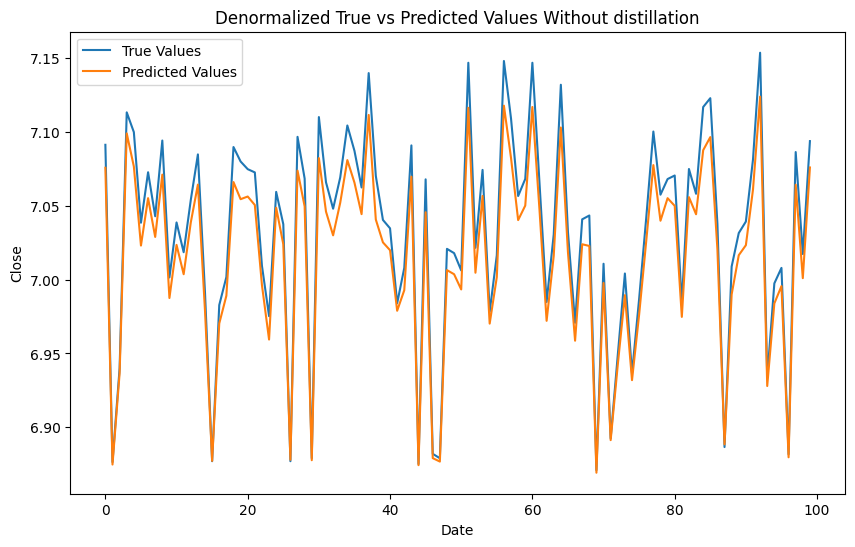

In [23]:
# 绘制预测值和真实值
plt.figure(figsize=(10, 6))
plt.plot(test_Y_denormalized_student_direct[:100, 1], label='True Values')
plt.plot(pred_Y_denormalized_student_direct[:100, 1], label='Predicted Values')
plt.title('Denormalized True vs Predicted Values Without distillation')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()